In [32]:
## Work with arrays
import numpy as np
## Make figures
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as mticker
## Draw maps
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.ticker import LatitudeLocator, LongitudeLocator
# Open netCDF-files
import netCDF4 as nc
# Manipulate data-frames
import pandas as pd
# Manipulate dates
import datetime as dt
from dateutil.relativedelta import relativedelta

from data_path import DATA_PATH_SROK8C

In [71]:
stations = pd.read_csv(DATA_PATH_SROK8C+"../catalog.csv")
stations[256:]

,Индекс ВМО,Наименование станции,Широта,Долгота,Высота,Начало наблюдений,Примечание,Unnamed: 7
256,28704,Чулпаново,54°30',50°25',76,1966,NaN,NaN
257,28719,Аксаково,54°02',54°09',350,1966,NaN,NaN
258,28722,Уфа,54°43',55°50',104,1966,NaN,NaN
259,28748,Троицк,54°05',61°37',192,1966,Перенос в 1974г. на 1км к ЗСЗ,NaN
260,28802,Серноводск,53°55',51°16',112,1966,Перенос в 1965г. на 1.5км к ССЗ,NaN
...,...,...,...,...,...,...,...,...
516,37461,"Сулак, высокогорная",42°22',46°15',2927,1966,NaN,NaN
517,37470,Дербент,42°04',48°18',-19,1966,NaN,NaN
518,37471,Буйнакск,42°49',47°07',472,1966,NaN,NaN
519,37472,Махачкала,43°01',47°29',-20,1966,"С 1966г. по 11.1991г. – Махачкала,АЭ, ЮВ окраи...",NaN


In [14]:
def converter(geoCoord: str):
    delimiter = geoCoord.find("°")
    if delimiter == -1:
        delimiter = geoCoord.find("о")
    if delimiter == -1:
        delimiter = geoCoord.find("o")
    return float(geoCoord[:delimiter]) + float(geoCoord[delimiter+1:delimiter+3])/60

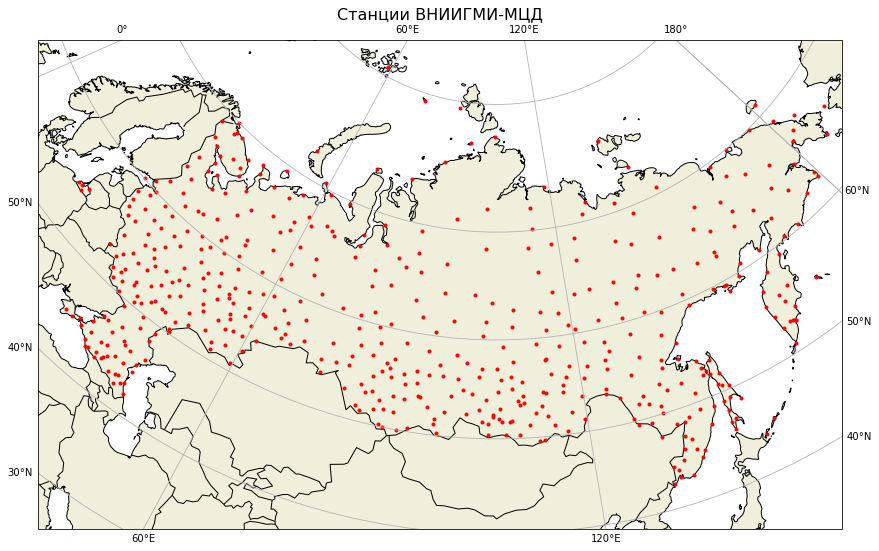

In [72]:
locs = np.empty((520,2))
for i in range(520):
    locs[i,0] = converter(stations["Широта"][i])
    locs[i,1] = converter(stations["Долгота"][i])   

fig = plt.figure(figsize=(16,9))
lambert_crs = ccrs.LambertConformal(central_longitude=105) 
ax = fig.add_subplot(1,1,1,
                     projection=lambert_crs
                    )
ax.set_extent(
    [35, 155, 40, 80], 
    crs=ccrs.PlateCarree()
)
gl = ax.gridlines(
    draw_labels=True, 
    dms=True, 
    x_inline=False,
    y_inline=False
)
gl.rotate_labels = False
ax.coastlines(resolution='50m')
for loc in locs:
    plt.plot(
        loc[1], loc[0], 
        transform=ccrs.PlateCarree(),
        marker='.', color='red'
    )
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS)
ax.set_title("Станции ВНИИГМИ-МЦД", fontsize=16)
fig.savefig("rihmi_wdc_stations.png", dpi=250)

In [127]:
np.arange(35,155+1,10)

array([ 35,  45,  55,  65,  75,  85,  95, 105, 115, 125, 135, 145, 155])

In [63]:
VALID_QUALITIES = [0, 1, 2]

def dictFromSrok8cDatFile(stationSynopticIndex: int):
    d = {
        "GMT year" : list(),
        "GMT month" : list(),
        "GMT day" : list(),
        "GMT time" : list(),
        "Horizontal visibility (km)" : list(),
        "Total cloudiness (points)" : list(),
        "Amount of low-level clouds (points)" : list(),
        "Shape of upper-level clouds" : list(),
        "Shape of middle-level clouds" : list(),
        "Shape of vertical development clouds" : list(),
        "Stratus and stratocumulus" : list(),
        "Nimbostratus and fracto-nimbus" : list(),
        "Cloud ceiling (m)" : list(),
        "Weather between observation hours" : list(),
        "Weather during observation hour" : list(),
        "Wind direction (degrees)" : list(),
        "Wind speed (m/s)" : list(),
        "Maximum wind speed (m/s)" : list(),
        "Precipitation total in the period between observation hours (mm)" : list(),
        "Soil surface temperature (°C)" : list(),
        "Minimum soil surface temperature (°C)" : list(),
        "Minimum soil surface temperature between observation hours (°C)" : list(),
        "Maximum soil surface temperature between observation hours (°C)" : list(),
        "Maximum thermometer temperature of soil surface (°C)" : list(),
        "Dry-bulb thermometer air temperature (°C)" : list(),
        "Wet-bulb thermometer air temperature (°C)" : list(),
        "Minimum air temperature between observation hours (°C)" : list(),
        "Maximum air temperature between observation hours (°C)" : list(),
        "Maximum thermometer air temperature (°C)" : list(),
        "Water vapour partial pressure (mbar)" : list(),
        "Relative air humidity (%)" : list(),
        "Water vapour saturation deficit (mbar)" : list(),
        "Dew point temperature (°C)" : list(),
        "Air pressure at station level (mbar)" : list(),
        "Air pressure at sea level (mbar)" : list(),
        "Characteristic of baric tendency" : list(),
        "Pressure tendency value (mbar)" : list()
    }
    
    with open(
        DATA_PATH_SROK8C
        + f"{stationSynopticIndex}.dat"
    ) as f:
        for line in f:
            # 0:4
            d["GMT year"] += [int(line[6:10])]
            d["GMT month"] += [int(line[11:13])]
            d["GMT day"] += [int(line[14:16])]
            d["GMT time"] += [int(line[17:19])]
            # 20:24 Year of source (local)
            # 25:27 Month of source (local)
            # 28:30 Day of source (local)
            # 31:33 Hour of source
            # 34:36 Number of hour in a day according to standard winter decree time (SWDT)
            # 37:39 Local time
            # 40:42 Number of time zone
            # 43:45 Meteorological day onset (SWDT)
            code = line[46:48]
            quality = int(line[49:50])
            idGT = line[51:52]
            d["Horizontal visibility (km)"] += [hrzVsbltInKm(code, quality, idGT)]
            code = line[53:55]
            quality = int(line[56:57])
            d["Total cloudiness (points)"] += [cldnssInPoints(code, quality)]
            code = line[58:60]
            quality = int(line[61:62])
            d["Amount of low-level clouds (points)"] += [cldnssInPoints(code, quality)]
            code = line[63:65]
            quality = int(line[66:67])
            d["Shape of upper-level clouds"] += [shpCld(code, quality)]
            code = line[68:70]
            quality = int(line[71:72])
            d["Shape of middle-level clouds"] += [shpCld(code, quality)]
            code = line[73:75]
            quality = int(line[76:77])
            d["Shape of vertical development clouds"] += [shpCld(code, quality)]
            code = line[78:80]
            quality = int(line[81:82])
            d["Stratus and stratocumulus"] += [shpCld(code, quality)]
            code = line[83:85]
            quality = int(line[86:87])
            d["Nimbostratus and fracto-nimbus"] += [shpCld(code, quality)]
            code = line[88:92]
            quality = int(line[93:94])
            method = line[95:96]
            d["Cloud ceiling (m)"] += [cldClng(code, quality, method)]
            # 97:99
            # 100:101
            code = line[102:104]
            quality = int(line[105:106])
            d["Weather between observation hours"] += [wthr(code, quality)]
            code = line[107:109]
            quality = int(line[110:111])
            d["Weather during observation hour"] += [wthr(code, quality)]
            code = line[112:115]
            quality = int(line[116:117])
            d["Wind direction (degrees)"] += [windDir(code, quality)]
            code = line[118:120]
            quality = int(line[121:122])
            idGT = line[123:124]
            d["Wind speed (m/s)"] += [windSpd(code, quality, idGT)]
            code = line[125:127]
            quality = int(line[128:129])
            idGT = line[130:131]
            d["Maximum wind speed (m/s)"] += [windSpd(code, quality, idGT)]
            code = line[132:138]
            quality = line[139:140]
            d["Precipitation total in the period between observation hours (mm)"] += [
                precip(code, quality)
            ]
            code = line[141:146]
            quality = line[147:148]
            d["Soil surface temperature (°C)"] += [temp(code, quality)]
            code = line[149:154]
            quality = line[155:156]
            d["Minimum soil surface temperature (°C)"] += [temp(code, quality)]
            code = line[157:162]
            quality = line[163:164]
            d["Minimum soil surface temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[165:170]
            quality = line[171:172]
            d["Maximum soil surface temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[173:178]
            quality = line[179:180]
            d["Maximum thermometer temperature of soil surface (°C)"] += [
                temp(code, quality)
            ]
            code = line[181:186]
            quality = line[187:188]
            d["Dry-bulb thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            code = line[189:194]
            quality = line[195:196]
            d["Wet-bulb thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            # 197:198 Identifier of ice on the lawn
            # 199:204 Minimum alcohol thermometer air temperature
            # 205:206 Quality flag
            code = line[207:212]
            quality = line[213:214]
            d["Minimum air temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[215:220]
            quality = line[221:222]
            d["Maximum air temperature between observation hours (°C)"] += [
                temp(code, quality)
            ]
            code = line[223:228]
            quality = line[229:230]
            d["Maximum thermometer air temperature (°C)"] += [
                temp(code, quality)
            ]
            code = line[231:236]
            quality = line[237:238]
            prec = line[239:240]
            d["Water vapour partial pressure (mbar)"] += [prs(code, quality, prec)]
            code = line[241:244]
            quality = line[245:246]
            d["Relative air humidity (%)"] += [rh(code, quality)]
            code = line[247:254]
            quality = line[255:256]
            prec = line[257:258]
            d["Water vapour saturation deficit (mbar)"] += [dfct(code, quality, prec)]
            code = line[259:264]
            quality = line[265:266]
            d["Dew point temperature (°C)"] += [
                temp(code, quality)
            ]
            code = line[267:273]
            quality = line[274:275]
            prec = "1"
            d["Air pressure at station level (mbar)"] += [prs(code, quality, prec)]
            code = line[276:282]
            quality = line[283:284]
            prec = "1"
            d["Air pressure at sea level (mbar)"] += [prs(code, quality, prec)]
            code = line[285:287]
            quality = line[288:289]
            d["Characteristic of baric tendency"] += [chrctrstcBrcTndnc(code, quality)]
            code = line[290:294]
            quality = line[295:296]
            d["Pressure tendency value (mbar)"] += [prssrTndncVal(code, quality)]
    return d
            
def prssrTndncVal(code: str, quality: int) -> float:
    res = np.nan
    if quality in VALID_QUALITIES:
        res = float(code)
    return res
            
def chrctrstcBrcTndnc(code: str, quality: int) -> int:
    res = -999
    if quality in VALID_QUALITIES:
        res = int(code)
    return res             
            
def dfct(code: str, quality: int, prec: str) -> float:
    res = np.nan
    if quality in VALID_QUALITIES:
        res = float(code)
        if prec == "1":
            res = np.round(res, -1)
        if prec == "2":
            res = np.round(res, -2)
    return res
            
def rh(code: str, quality: int) -> float:
    res = np.nan
    if quality in VALID_QUALITIES:
        res = float(code)
    return res
            
def prs(code: str, quality: int, prec: str) -> float:
    res = np.nan
    if quality in VALID_QUALITIES:
        res = float(code)
        if prec == "1":
            res = np.round(res, -1)
        if prec == "2":
            res = np.round(res, -2)
    return res

def temp(code: str, quality: int) -> float:
    res = np.nan
    if quality in VALID_QUALITIES:
        res = float(code)
    return res            
            
def precip(code: str, quality: int) -> float:
    res = np.nan
    if quality in VALID_QUALITIES:
        res = float(code)
    return res

def windSpd(code: str, quality: int, idGT: str) -> float:
    res = np.nan
    if quality in VALID_QUALITIES and idGT == "0":
        res = float(code)
    return res
            
def windDir(code: str, quality: int) -> float:
    NO_WIND = np.nan
    DIFF_DIRS = np.nan
    res = np.nan
    if quality in VALID_QUALITIES:
        if int(code) > 0 and int(code) <= 360:
            res = float(code)
        elif int(code) == 0:
            res = NO_WIND
        elif int(code) == 999:
            res = DIFF_DIRS
    return res    

def wthr(code: str, quality: int) -> int:
    res = -999
    if quality in VALID_QUALITIES:
        res = int(code)
    return res                
            
def cldClng(code: str, quality: int, method: str) -> float:
    res = np.nan
    if quality in VALID_QUALITIES and code != "    ":
        res = float(code)
    return res

def shpCld(code: str, quality: int) -> int:
    res = -999
    if quality in VALID_QUALITIES:
        res = int(code)
    return res    
    
def cldnssInPoints(code: str, quality: int) -> float:
    CLDNSS_11 = np.nan #11
    CLDNSS_12 = np.nan #12
    CLDNSS_13 = np.nan #13
    res = np.nan
    if quality in VALID_QUALITIES and code != "99":
        if code == "11":
            res = CLDNSS_11
        elif code == "12":
            res = CLDNSS_12
        elif code == "13":
            res = CLDNSS_13
        else:
            res = float(code)
    return res        

def hrzVsbltInKm(code: str, quality: int, idGT: str) -> float:
    LT_01KM = np.nan #0.1 * (1.0 - 0.5)
    LT_005KM = np.nan #0.05 * (1.0 - 0.5)
    GT_70KM = np.nan #70.0 * (1.0 + 0.5)
    GT_50KM = np.nan #50.0 * (1.0 + 0.5)
    res = np.nan
    if quality in VALID_QUALITIES and idGT == " ":
        if code == "00":
            res = LT_01KM
        elif code in genCodes(1, 50+1):
            res = float(int(code)) / 10.0
        elif code in genCodes(56, 80+1):
            res = float(code) - 50.0
        elif code in genCodes(81, 88+1):
            res = (float(code) - 76.0) * 5.0
        elif code == "89":
            res = GT_70KM
        elif code == "90":
            res = LT_005KM
        elif code == "91":
            res = 0.05
        elif code == "92":
            res = 0.2
        elif code == "93":
            res = 0.3
        elif code == "94":
            res = 1.0
        elif code == "95":
            res = 2.0
        elif code == "96":
            res = 4.0
        elif code == "97":
            res = 10.0
        elif code == "98":
            res = 20.0
        elif code == "99":
            res = GT_50KM    
    return res

def genCodes(start, end):
    res = list()
    if end > 99:
        return np.nan
    for i in range(start, end):
        if i < 10:
            res += [f"0{i}"]
        else:
            res += [f"{i}"]
    return res

In [64]:
files = !!(ls $DATA_PATH_SROK8C)
indices = [int(file[:-4]) for file in files]

In [65]:
d = dictFromSrok8cDatFile(indices[256])
import pandas as pd
df = pd.DataFrame(data=d)
df

,GMT year,GMT month,GMT day,GMT time,Horizontal visibility (km),Total cloudiness (points),Amount of low-level clouds (points),Shape of upper-level clouds,Shape of middle-level clouds,Shape of vertical development clouds,...,Maximum air temperature between observation hours (°C),Maximum thermometer air temperature (°C),Water vapour partial pressure (mbar),Relative air humidity (%),Water vapour saturation deficit (mbar),Dew point temperature (°C),Air pressure at station level (mbar),Air pressure at sea level (mbar),Characteristic of baric tendency,Pressure tendency value (mbar)
0,1965,12,31,18,NaN,NaN,0.0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
1,1965,12,31,21,NaN,10.0,10.0,8,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
2,1966,1,1,0,NaN,10.0,10.0,8,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
3,1966,1,1,3,NaN,10.0,10.0,8,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
4,1966,1,1,6,NaN,10.0,10.0,8,8,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166547,2022,12,31,3,NaN,10.0,0.0,8,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
166548,2022,12,31,6,NaN,10.0,0.0,8,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
166549,2022,12,31,9,NaN,10.0,0.0,8,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN
166550,2022,12,31,12,NaN,10.0,0.0,8,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,NaN


In [70]:
df[:10].transpose()

,0,1,2,3,4,5,6,7,8,9
GMT year,1965.0,1965.0,1966.0,1966.0,1966.0,1966.0,1966.0,1966.0,1966.0,1966.0
GMT month,12.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GMT day,31.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
GMT time,18.0,21.0,0.0,3.0,6.0,9.0,12.0,15.0,18.0,21.0
Horizontal visibility (km),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total cloudiness (points),NaN,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
Amount of low-level clouds (points),0.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,10.0
Shape of upper-level clouds,1.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0
Shape of middle-level clouds,1.0,8.0,8.0,8.0,8.0,8.0,8.0,2.0,2.0,8.0
Shape of vertical development clouds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/home/mrk/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/tmp/ipykernel_5828/4222971394.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _ = sns.displot(df, x=col, kind="kde")


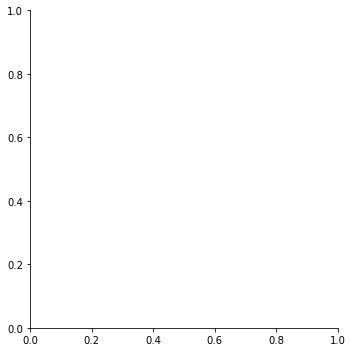

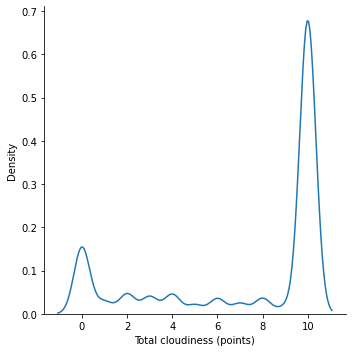

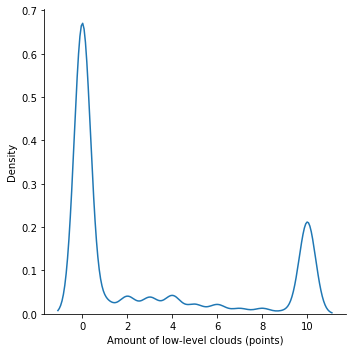

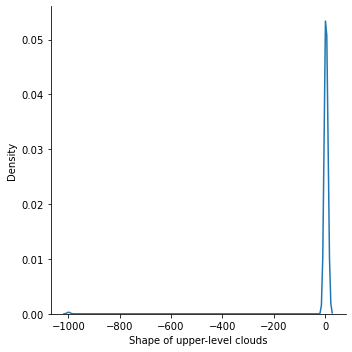

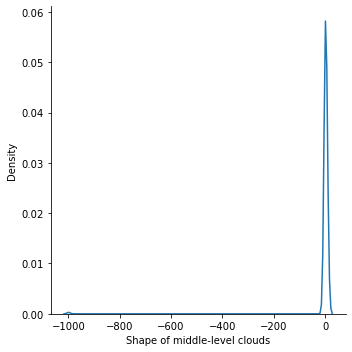

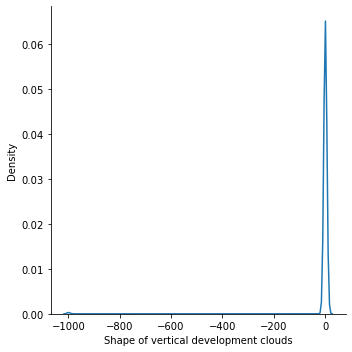

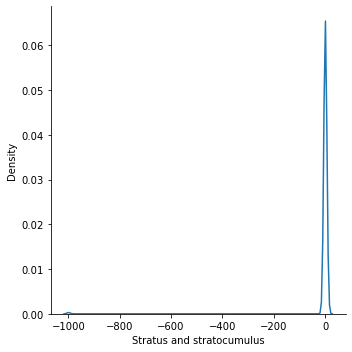

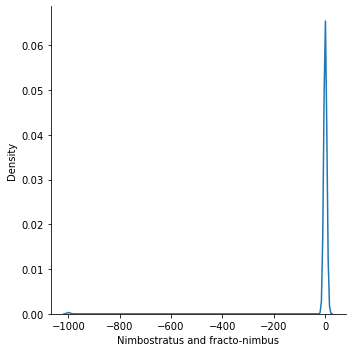

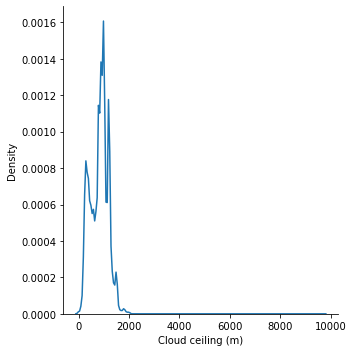

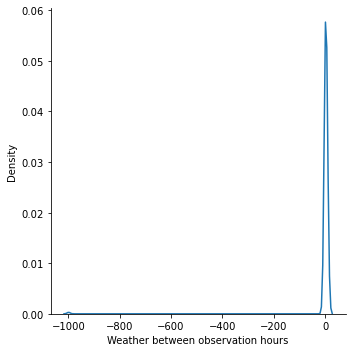

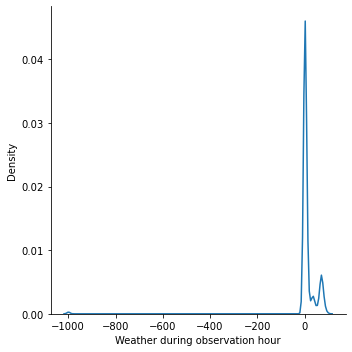

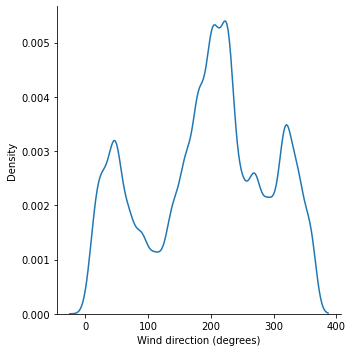

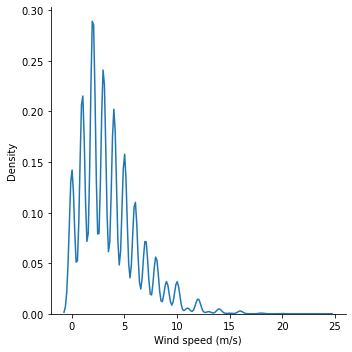

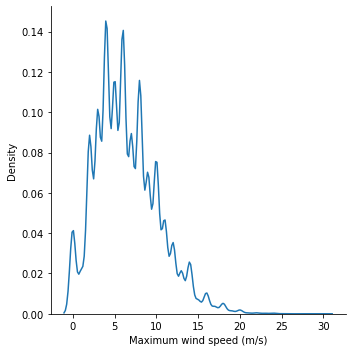

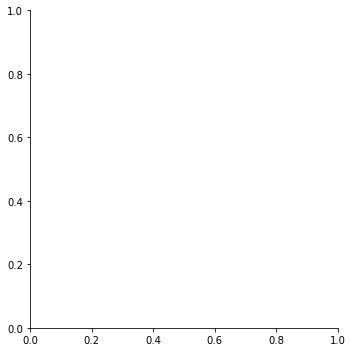

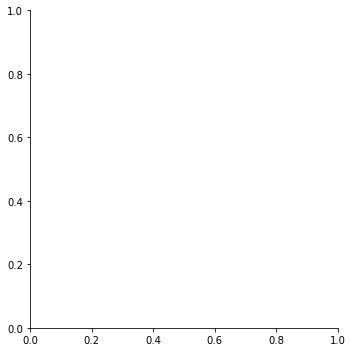

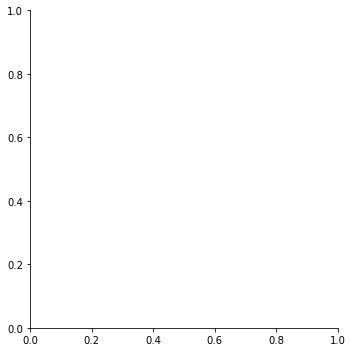

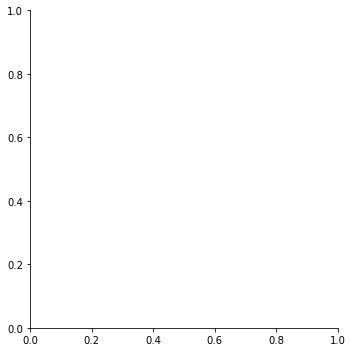

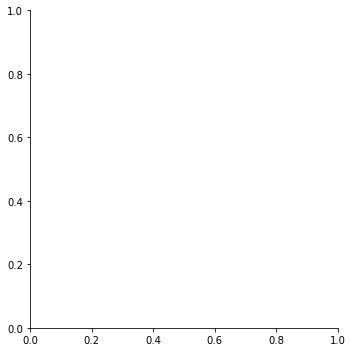

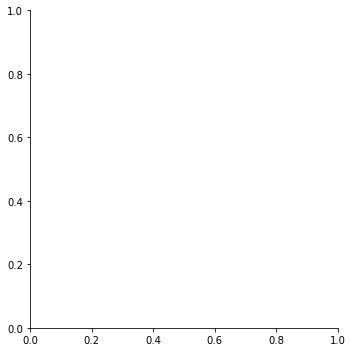

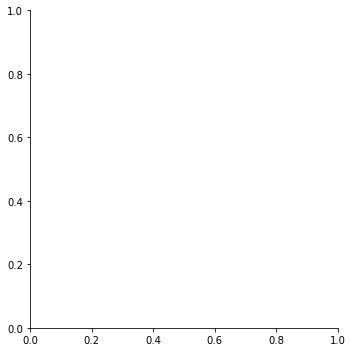

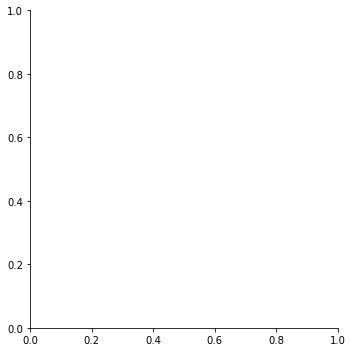

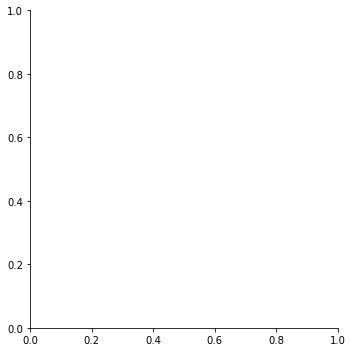

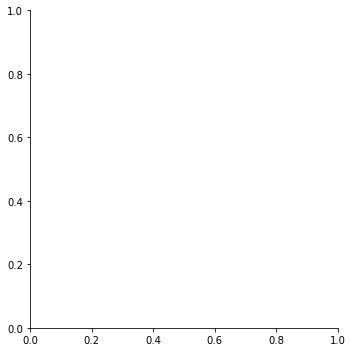

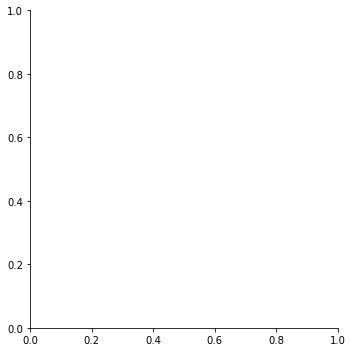

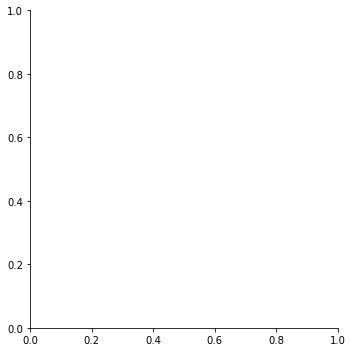

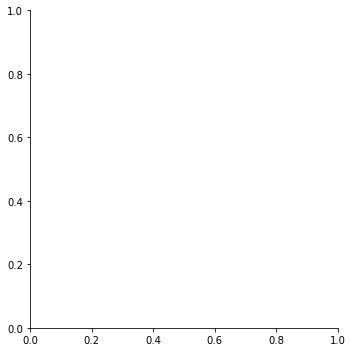

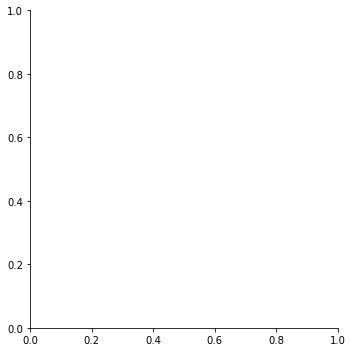

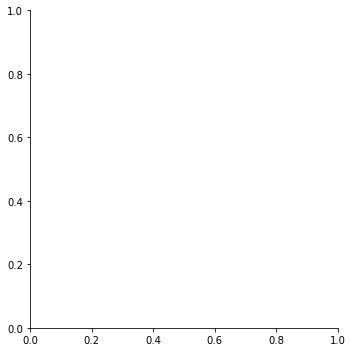

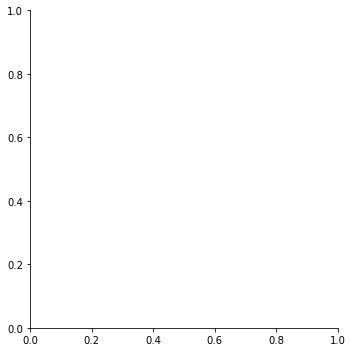

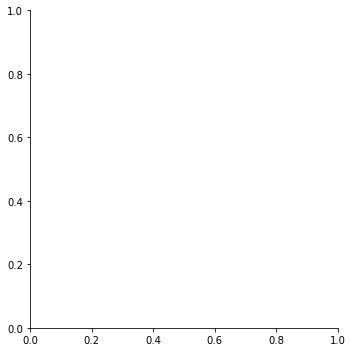

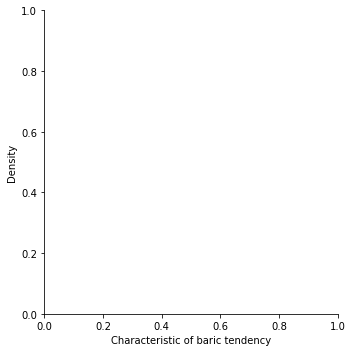

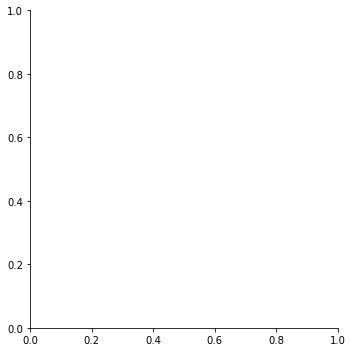

In [75]:
import seaborn as sns
for col in df.columns[4:]:
    _ = sns.displot(df, x=col, kind="kde")